# Distribution View

The distribution view allows to explore large-scale live-cell imaging data and focus on single-cell property distributions to find and investigate rare events or temporal developments. Therefore, we provide cell size, length, and age distributions to filter interesting candidates that are visualized as overlays on the microscope image. Moreover, the temporal development of the selected and not selected cells by the filter are visualized in terms of total cell area and count.

Have fun 🚀 executing the notebook yourself, experience the freedom of customization in jupyter notebooks, and have a look at the video below 👇 

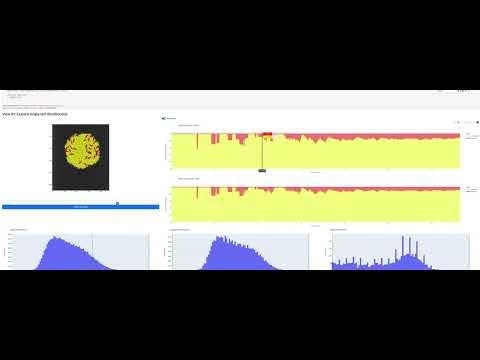

In [26]:
from IPython.display import YouTubeVideo

YouTubeVideo('qScXv45kyOU', width=800, height=300)

## 1. Install dependencies

In [ ]:
!pip install imagecodecs==2023.9.18 igraph==0.11.3 dash[diskcache]==2.14.1 dash-bootstrap-components==1.5.0 multiprocess==0.70.15 "git+https://jugit.fz-juelich.de/publications/acia-pre.git@c989af4c3007882239dd724a2f3a8b13715d0c88#acia" moviepy==1.0.3 ipywidgets==8.1.1

## 2. Load segmentation & tracking information

In [ ]:
# download data
!wget -O data.zip https://fz-juelich.sciebo.de/s/3Ng8f6LG8Ed02zi/download

!mkdir data
!unzip -o data.zip -d data
!mkdir assets

In [ ]:
# Meta-information

pixel_size = 0.072 # micrometer/pixel
frame_step = 1/60 # 1 frame/minute

image_path = "data/03/image_stack.tiff"
seg_and_track_file = "data/03/simpleTracking.json"

In [ ]:
from acia.tracking.formats import parse_simple_tracking

# load segmentation and tracking information from file
with open(seg_and_track_file, "r") as tf:
    ov, tracking_graph = parse_simple_tracking(tf.read())


In [ ]:
from tqdm.auto import tqdm

from shapely.geometry import Polygon
import numpy as np
import pandas as pd

def pairwise_distances(points: np.ndarray):
    distances = []

    if len(points) == 0:
        return distances

    for a, b in zip(points, points[1:]):
        distances.append(np.linalg.norm(a - b))

    return distances

# load single-cell information into pandas data frame
cell_df = pd.DataFrame([
    {
        "id": cont.id,
        "frame": cont.frame,
        "area": cont.area * (pixel_size **2),
        "length": np.max(pairwise_distances(np.array(cont.polygon.minimum_rotated_rectangle.exterior.coords))) * pixel_size,
        "contour_coordinates": cont.coordinates,
        "time": cont.frame * frame_step
    } for cont in tqdm(ov)])

In [ ]:
cell_df

In [ ]:
from acia.tracking.utils import life_cycle_lineage

# create lifecycle lineage (one cell life one node in the graph, in contrast to one cell detection one node in the graph)
lc_lineage = life_cycle_lineage(tracking_graph)

In [ ]:
# load tracking (temporal) information into pandas data frame
lc_df = pd.DataFrame([{"track_id": n, "predecessors": list(lc_lineage.predecessors(n)), "successors": list(lc_lineage.successors(n)), "cycle": lc_lineage.nodes[n]["cycle"], "start_frame": lc_lineage.nodes[n]["start_frame"], "end_frame": lc_lineage.nodes[n]["end_frame"], "age": len(lc_lineage.nodes[n]["cycle"])  * frame_step} for n in lc_lineage.nodes])

lc_df

In [ ]:
import tifffile
import numpy as np

# cache the image data
images = tifffile.imread(image_path)
# make them rgb
if len(images.shape) == 3 or (len(images.shape) == 4 and images.shape[-1] == 1):
    images = np.stack([images] * 3, axis=-1)
print(images.shape)

## 3. Utility functionalities

In [ ]:
lc_lookup = {det_id: track_id for track_id in lc_lineage.nodes() for det_id in lc_lineage.nodes[track_id]["cycle"]}

In [ ]:
from acia.base import Overlay

def get_frame_overlay(frame: int):
    
    # operate on the dataframe
    return cell_df[cell_df["frame"] == frame] 

In [ ]:
def get_image_figure(frame:int, selection=None, cell_info=None):
    """
    Creates a plotly figure with images and selected/unselected cell overlay
    """
    
    # use only the first channel for the image
    image = images[frame][...,0]
    
    # Render image into figure
    compression_level=8
    fig = px.imshow(image, binary_string=True, binary_compression_level=compression_level)

    if selection is not None:
        selection = set(selection)
    
    fig.update_layout(autosize=True)

    # obtain the segmentation of the frame
    frame_df = get_frame_overlay(frame)
    
    # loop over all contours in this frame and create an overlay trace in plotly
    for _,contour in frame_df.iterrows():
        
        coordinates = np.concatenate([contour["contour_coordinates"], contour["contour_coordinates"][0:1]])
        x_array = np.array(coordinates[:,0])
        y_array = np.array(coordinates[:,1])

        color = (255,255,0)
        if selection is not None:
            if contour.id in selection:
                color = (255, 0, 0)

        text = f'I am cell {contour.id}'
        if cell_info is not None:
            text = cell_info[contour.id]

        # Adding a trace with a fill, setting opacity to 0
        fig.add_trace(
            go.Scatter(
                x=x_array, 
                y=y_array, 
                fill="toself",
                fillcolor=f'rgba{tuple([*color, 0.5])}',
                mode='lines',
                line=dict(
                    color=f"rgb{color}",
                    width=2
                ),
                name=f'Cell id: {contour.id}',
                text=text,
            )
        )

    return fig

In [ ]:
def compute_selection(data, min, max, mode):
    low = np.quantile(data, min / 100)
    high = np.quantile(data, max / 100)
    
    data = np.array(data)
    
    print(low, high)    
    
    selection = (low <= data) & (data <= high)
    if mode == "Exclusive":
        selection = ~selection # invert the selection
        
    return selection, low, high

In [ ]:
from tqdm.auto import tqdm
import dash
import uuid
import cv2
import moviepy.editor as mpy


def render_video(cell_df, selection_mask=None):
    
    uid = uuid.uuid4()
    thickness = 2
    
    selected_df = cell_df.iloc[selection_mask]
    unselected_df = cell_df.iloc[~selection_mask]

    video_images = []
    for frame in tqdm(np.unique(cell_df["frame"])):
        frame_image = np.copy(images[frame])#source.get_frame(frame).raw
        
        font = cv2.FONT_HERSHEY_SIMPLEX 

        # org 
        org = (50, 50) 

        # fontScale 
        fontScale = 0.5

        # Blue color in RGB 
        color = (255, 255, 255) 

        # Line thickness of 2 px 
        thickness = 2
        
        cv2.putText(frame_image, f"Frame {frame:02d}", org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
        
        sel_frame_df = selected_df[selected_df["frame"] == frame]
        unsel_frame_df = unselected_df[unselected_df["frame"] == frame]

        cv2.polylines(frame_image, [np.array(cell_data["contour_coordinates"]).astype(np.int32) for _,cell_data in sel_frame_df.iterrows()], True, (255, 0, 0), thickness)
        cv2.polylines(frame_image, [np.array(cell_data["contour_coordinates"]).astype(np.int32) for _,cell_data in unsel_frame_df.iterrows()], True, (255, 255, 0), thickness)

        video_images.append(frame_image)
        
    clip =  mpy.ImageSequenceClip(video_images, fps=10)
    crf=23
    filename=f"assets/test-{uid}.mp4"
    clip.write_videofile(
            filename, 
            codec='vp9',ffmpeg_params=["-quality", "realtime", "-speed", "4"] # preset="ultrafast", ffmpeg_params=["-crf", str(crf)],
    )

    return filename

## 4. Compute single-cell stats

In [ ]:
from pandas import DataFrame

track_lookup = {det_id: n for n in lc_lineage.nodes for det_id in lc_lineage.nodes[n]["cycle"]}

In [ ]:
# add track id to every cell detection
cell_df["track_id"] = cell_df["id"].map(lambda cid: track_lookup[cid])

In [ ]:
# compute the amount of smaller cells
cell_df["area_smaller"] = cell_df.apply(lambda x: np.sum(cell_df['area'] <= x['area']) / len(cell_df), axis=1)

In [ ]:
# add trajectory age to every cell detection
cell_df["track_age"] = cell_df["track_id"].map(lambda track_id: lc_df[lc_df["track_id"] == track_id].iloc[0]["age"])

In [ ]:
cell_df

In [ ]:
cell_df["age_younger"] = cell_df.apply(lambda x: np.sum(lc_df["age"] <= x["track_age"]) / len(lc_df), axis=1)

In [ ]:
cell_df["cell_info"] = cell_df.apply(lambda x: f"I am cell {x['id']}<br />", axis=1) #Cell detection info:<br />area: { x['area_smaller'] * 100:.1f }% <= {x['area']} <= {(1 - x['area_smaller']) * 100:.1f}%<br /><br />Cell track info:<br />age: {x['age_younger'] * 100:.1f}% <= {x['track_age']} <= {(1 - x['age_younger']) * 100:.1f}%", axis=1)

cell_info = {x['id']: x['cell_info'] for _, x in cell_df.iterrows()}

In [ ]:
for _, x in tqdm(cell_df[["id", "track_age"]].iterrows()):
    track_id = lc_lookup[x["id"]]
    assert len(lc_lineage.nodes[track_id]["cycle"]) * frame_step == x["track_age"]

In [ ]:
cell_df

## 5. Create the interactive visualization

In [ ]:
from IPython.display import Video, Markdown, display
import dash_bootstrap_components as dbc

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


import plotly.io as pio
import plotly.express as px

from dash import Dash, dcc, html, Input, Output, callback, no_update, State, ctx
import os
import json

from PIL import Image
from pandas import DataFrame
import pandas as pd
import plotly.figure_factory as ff
from functools import reduce

from dash.long_callback import DiskcacheLongCallbackManager

## Create Diskcache (for long running video creation)
import diskcache
cache = diskcache.Cache("./cache")
long_callback_manager = DiskcacheLongCallbackManager(cache)

min_frame = 0
max_frame = len(images) - 1

# extract single-cell properties for filtering
areas = np.array(cell_df["area"])
ages = np.array(cell_df["track_age"])
lengths = np.array(cell_df["length"])


app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

#############################
### Create the App layout ###
#############################

app.layout = html.Div([
    dcc.Store(id='memory'),
    dbc.Row([
        dbc.Col([
            # graph for microscope image
            dcc.Loading(dcc.Graph(id="image")),
            # frame slider
            dbc.Col(dcc.Slider(min_frame, max_frame, step=1, value=5, id='frame-slider', tooltip={"placement": "bottom", "always_visible": True}, marks={0: '0', max_frame: f'{max_frame}'},), width=12),
            # video download button
            dbc.Col(html.Div(dbc.Button("Download Video", id="btn_video", color="primary"), className="d-grid gap-2"), width=12),
            dcc.Download(id="download-video")
        ], width=4),
        dbc.Col([
            # normalize button
            dbc.Row([
                dbc.Checklist(
                    options=[
                        {"label": "Normalize", "value": "normalize"},
                    ],
                    value=[],
                    id="normalized-input",
                    switch=True,
                ),
            ]),
            # cell size graph
            dbc.Row(dcc.Loading(dcc.Graph(id="lineage", mathjax=True))),
            # cell count graph
            dbc.Row(dcc.Loading(dcc.Graph(id="counts", mathjax=True))),
        ], width=8),

    ]),
    dbc.Row([
        # distribution for cell area
        dbc.Col(dcc.Loading([
            dcc.Graph(id="area-dist", mathjax=True),
            dcc.RadioItems(['Inclusive', 'Exclusive'], 'Inclusive', id="area-radio"),
            dcc.RangeSlider(0, 100, value=[0, 100], id='area-slider', allowCross=False, tooltip={"placement": "bottom", "always_visible": True}, marks={0: '0', 100: f'100'},)
        ]), width=4),
        # distribution for cell length
        dbc.Col(dcc.Loading([
            dcc.Graph(id="end-area-ratio", mathjax=True),#figure=age_fig, id="age-dist"),
            dcc.RadioItems(['Inclusive', 'Exclusive'], 'Inclusive', id="length-radio"),
            dcc.RangeSlider(0, 100, value=[0, 100], id='length-slider', allowCross=False, tooltip={"placement": "bottom", "always_visible": True}, marks={0: '0', 100: f'100'},),
        ]), width=4),
        # distribution for cell age
        dbc.Col(dcc.Loading([
            dcc.Graph(id="age-dist", mathjax=True),
            dcc.RadioItems(['Inclusive', 'Exclusive'], 'Inclusive', id="age-radio"),
            dcc.RangeSlider(0, 100, value=[0, 100], id='age-slider', allowCross=False, tooltip={"placement": "bottom", "always_visible": True}, marks={0: '0', 100: f'100'},),
        ]), width=4),
    ])
])

@app.callback(
    Output("memory", "data"),
    Output("lineage", "figure"),
    Output("counts", "figure"),
    Output("image", "figure"),
    Output("area-dist", "figure"),
    Output("age-dist", "figure"),
    Output("end-area-ratio", "figure"),
    Input("normalized-input", "value"),
    Input("image", "clickData"),
    Input("frame-slider", "value"),
    Input("area-slider", "value"),
    Input("area-radio", "value"),
    Input("length-slider", "value"),
    Input("length-radio", "value"),
    Input("age-slider", "value"),
    Input("age-radio", "value"),
    State("memory", "data")
)
def update_figures(normalized_input, target_click, frame_slider, area_slider, area_radio, length_slider, length_radio, age_slider, age_radio, data):
    trigger_id = ctx.triggered_id
    print(trigger_id)
    print(frame_slider)
    print(area_slider)
    print(age_slider)
    #print(start_click)
    
    if data is None:
        data = {}
        data["start_selection"] = []
    
    # frame selected by the slider
    target_frame = frame_slider

    # compute area and length selections
    area_selection, area_low, area_high = compute_selection(areas, area_slider[0], area_slider[1], area_radio)
    length_mask, length_low, length_high = compute_selection(lengths, length_slider[0], length_slider[1], length_radio)
    

    # compute age selection (a bit more difficult, because it affects full trajectories of cells)
    low = np.quantile(lc_df["age"], age_slider[0] / 100)
    high = np.quantile(lc_df["age"], age_slider[1] / 100)
    
    
    inclusive_set_selection = (low <= ages) & (ages <= high)
    print(inclusive_set_selection)
    if age_radio == "Inclusive":
        age_subset = ages[inclusive_set_selection]
    else:
        age_subset = ages[~inclusive_set_selection]

    
    sc_age_mask = inclusive_set_selection #cell_df["id"].isin(sc_age_selection)

    
    # fuse all selections into a mask
    total_selection_mask = area_selection & sc_age_mask & length_mask
    total_selection = set(cell_df["id"][total_selection_mask])
    

    # create the image figure using the selection mask
    end_fig = get_image_figure(target_frame, total_selection, cell_info)
    end_fig.update_layout(
        height=700,
        showlegend=False
    )
    
    ##########################################
    # Create area and count over time figure #
    ##########################################
    
    area_df = cell_df[["id", "frame", "area", "time"]]
    length_df = cell_df[["id", "frame", "length", "time"]]
    age_df = cell_df[["id", "frame", "track_age", "time"]]
    
    # selected cell areas
    df_unselected = area_df[~total_selection_mask].groupby("time").agg("sum").reset_index()
    df_selected = area_df[total_selection_mask].groupby("time").agg("sum").reset_index()
    df_selected["type"] = "selected"
    df_unselected["type"] = "unselected"
    
    # selected cell counts
    df_unselected_sizes = area_df[~total_selection_mask].groupby("time").size().reset_index(name="cell_count")
    df_selected_sizes = area_df[total_selection_mask].groupby("time").size().reset_index(name="cell_count")
    df_selected_sizes["type"] = "selected"
    df_unselected_sizes["type"] = "unselected"
    
    fig = go.Figure()
    
    df_area = pd.concat([df_unselected, df_selected])
    df_counts = pd.concat([df_unselected_sizes, df_selected_sizes])
    
    # compute normalized values
    grouped = df_area.groupby("time")
    df_area['area_norm'] = grouped['area'].transform(lambda x: x/x.sum())

    grouped = df_counts.groupby("time")
    df_counts['cell_count_norm'] = grouped['cell_count'].transform(lambda x: x/x.sum())
    
    # based on normalizer button choose which data column to use
    y_post = ''
    if "normalize" in normalized_input:
        y_post = "_norm"
        
    color_discrete_map= {"selected": "rgb(255, 0, 0)", "unselected": "rgb(255, 255, 0)"}
    
    # create the figures
    figures = [
        px.area(df_area, x="time", y="area" + y_post, color="type", title="Cell Area Over Time", color_discrete_map=color_discrete_map),
        px.area(df_counts, x="time", y="cell_count" + y_post, color="type", title="Cell Count Over Time", color_discrete_map=color_discrete_map),
    ]
    
    for figure in figures:
        figure.update_layout(
            xaxis=dict(
                spikemode  = 'across+toaxis', spikedash = 'solid'
            ),
            xaxis_title="Time [hour]",
            margin=dict(
                r=0,
                b=0,
            ),
            height=400
        )
        figure.update_traces(hovertemplate=None)
        figure.update_layout(hovermode="x")
        
    figures[0].update_layout(
        yaxis_title=r"$\text{Total cell area [} \mu m \text{]}$"
    )
    figures[1].update_layout(
        yaxis_title=r"$\text{Total cell count}$"
    )
    
    ##########################
    # Create histogram plots #
    ##########################
    
    area_fig = px.histogram(cell_df, x="area", nbins=100)
    
    area_fig.update_layout(
        title="Area Distribution",
        autosize=True,
        xaxis_title=r"$\text{Cell size [} \mu m^2 \text{]}$",
        yaxis_title="Frequency",
    )
    
    area_fig.add_vline(x=area_low, line_width=3, line_dash="dash", line_color="green")
    area_fig.add_vline(x=area_high, line_width=3, line_dash="dash", line_color="green")

            
    age_fig = px.histogram(lc_df, x="age", nbins=100)
    
    age_fig.add_vline(x=low, line_width=3, line_dash="dash", line_color="green")
    age_fig.add_vline(x=high, line_width=3, line_dash="dash", line_color="green")

    age_fig.update_layout(
        title="Age Distribution",
        xaxis_title="Cell age [hour]",
        yaxis_title="Frequency",
    )
    
    length_fig = px.histogram(cell_df, x="length", nbins=100)
    
    length_fig.add_vline(x=length_low, line_width=3, line_dash="dash", line_color="green")
    length_fig.add_vline(x=length_high, line_width=3, line_dash="dash", line_color="green")

    
    length_fig.update_layout(
        title="Length Distribution",
        autosize=True,
        xaxis_title=r"$\text{Cell length [} \mu m \text{]}$",
        yaxis_title="Frequency",
    )
    
    
    return {"mask": total_selection_mask}, figures[0], figures[1], end_fig, area_fig, age_fig, length_fig

@app.long_callback(
    Output("download-video", "data"),
    Input("btn_video", "n_clicks"),
    Input("memory", "data"),
    prevent_initial_call=True,
    manager=long_callback_manager,
)
def gen_video(clicks, data):
    trigger_id = ctx.triggered_id
    
    if trigger_id != "btn_video":
        return None
    
    # 1. gen video file
    
    print("Start generating video file...")
    
    #print(gen_video)
    output_file = render_video(cell_df, np.array(data["mask"], bool))
    
    return dcc.send_file(
        output_file
    )


display(Markdown("# View 03: Explore single-cell distributions"))
app.run_server(port=8052, jupyter_mode="inline", jupyter_height=1600)